import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
import json
import time

from dotenv import load_dotenv
import google.generativeai as genai
from google.api_core.exceptions import ResourceExhausted


c:\Users\marcela\Documents\pruebas_tecnicas\meli\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup y carga de datos


In [2]:
import pandas as pd

df = pd.read_csv("../data/precios_historicos.csv")
df["ORD_CLOSED_DT"] = pd.to_datetime(df["ORD_CLOSED_DT"])
df = df.sort_values(["ITEM_ID", "ORD_CLOSED_DT"])

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 175914 entries, 175902 to 72
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ITEM_ID        175914 non-null  object        
 1   ORD_CLOSED_DT  175914 non-null  datetime64[ns]
 2   PRICE          175914 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.4+ MB
None


,ITEM_ID,ORD_CLOSED_DT,PRICE
175902,MLB1073354076,2023-12-20,533.21
175910,MLB1073354076,2023-12-20,497.00
175883,MLB1073354076,2023-12-26,426.00
175885,MLB1073354076,2023-12-26,979.80
175875,MLB1073354076,2024-01-02,1519.40


In [3]:
print("N registros:", len(df))
print("N productos únicos:", df["ITEM_ID"].nunique())

# Ejemplo: ver cuántas observaciones tiene un producto concreto
df["ITEM_ID"].value_counts().head()

N registros: 175914
N productos únicos: 300


ITEM_ID
MLB3836655204    96448
MLB3836681004    48709
MLB3836669552     2949
MLB3687444228      251
MLB3687430524      198
Name: count, dtype: int64

In [4]:
example_item = df["ITEM_ID"].value_counts().index[0]  # el más frecuente, por ejemplo

df_item = df[df["ITEM_ID"] == example_item].copy()


In [5]:
df_item.describe()

,ORD_CLOSED_DT,PRICE
count,96448,96448.000000
mean,2024-02-02 04:57:30.995354880,76.062967
min,2023-12-13 00:00:00,1.924100
25%,2024-01-15 00:00:00,22.478600
50%,2024-02-05 00:00:00,47.499000
75%,2024-02-21 00:00:00,98.256900
max,2024-03-11 00:00:00,2067.825300
std,NaN,85.580100


## EDA rápida por producto

En esta sección se seleccionan algunos `ITEM_ID` representativos y se visualizan sus series de precios para entender rangos típicos y posibles outliers. Esto ayuda a ajustar los umbrales de anomalía antes de definir el modelo clásico y el LLM.

In [6]:
# Seleccionar algunos ITEM_ID representativos y graficar sus series

# Productos con más observaciones
top_items = df["ITEM_ID"].value_counts().head(5).index.tolist()


In [7]:
# por cada item calcular las cescriptivas
df_top = df[df["ITEM_ID"].isin(top_items)].copy()

desc_price = df_top.groupby("ITEM_ID")["PRICE"].describe(
    percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
)

desc_price

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
ITEM_ID,,,,,,,,,,,,
MLB3687430524,198.0,129.631441,5.829644,123.5329,123.5329,123.54000,124.9600,128.08755,130.85300,141.92900,143.540416,144.5773
MLB3687444228,251.0,131.625853,6.310556,123.5329,123.5329,123.53645,124.9600,130.64000,135.32955,141.92900,147.161700,148.3829
MLB3836655204,96448.0,76.062967,85.580100,1.9241,3.4151,7.46210,22.4786,47.49900,98.25690,235.72000,401.259482,2067.8253
MLB3836669552,2949.0,258.816288,197.475362,4.9700,39.7600,57.64490,117.2849,206.75200,335.97200,703.75200,947.487900,1260.3991
MLB3836681004,48709.0,95.749039,113.222534,3.3299,4.6150,11.07600,31.7086,61.56410,116.51100,295.34296,561.801700,3118.6892


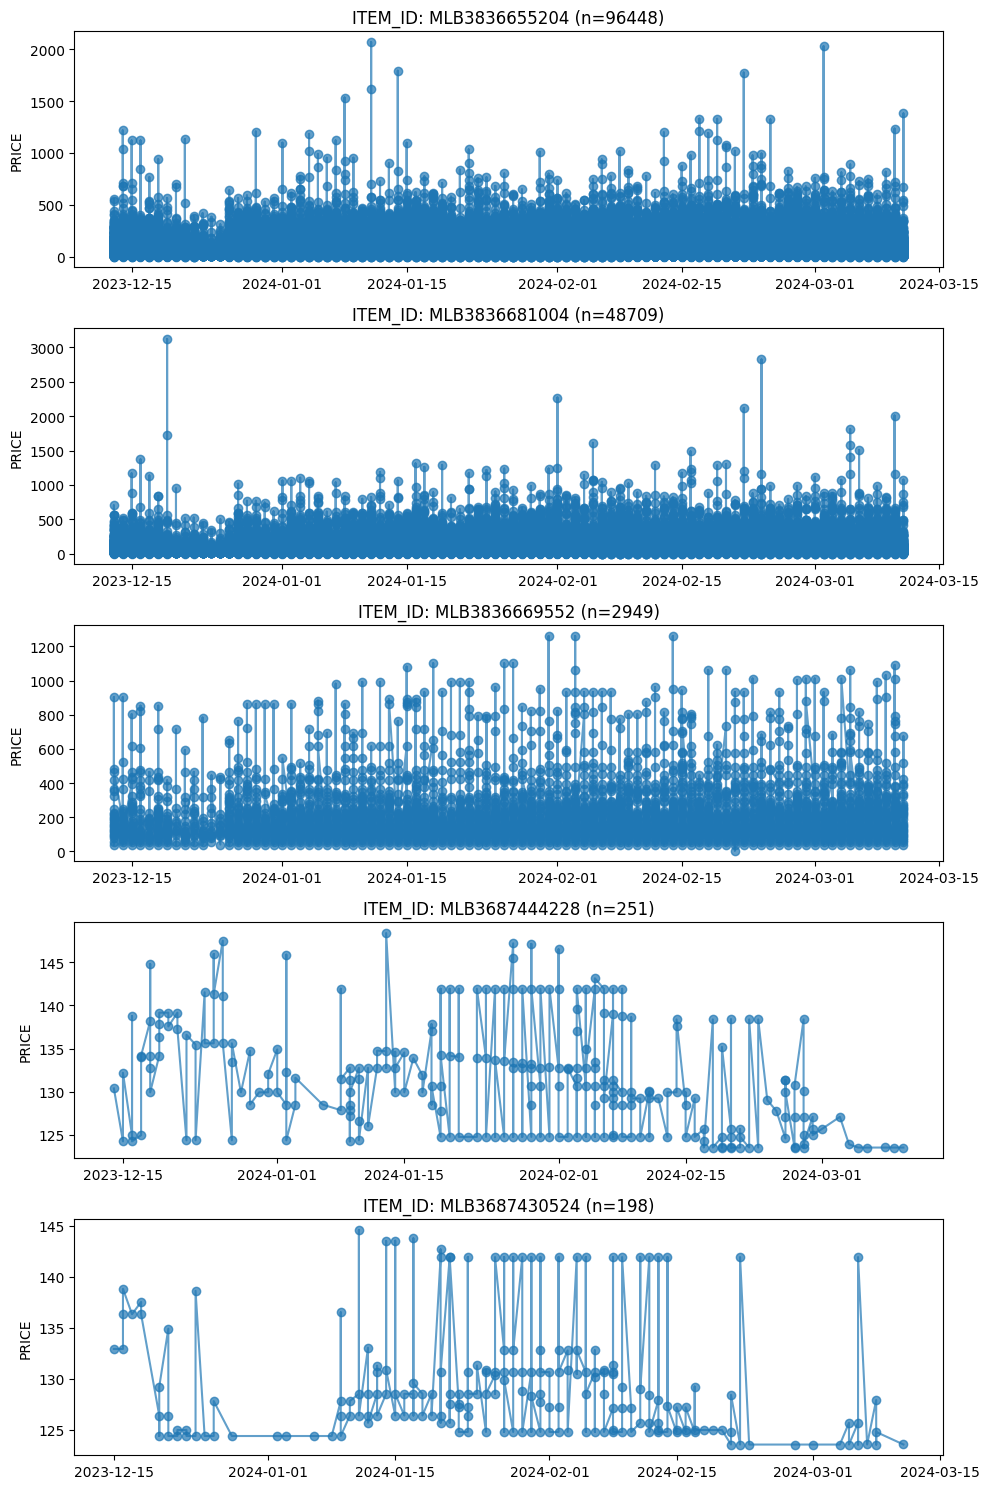

In [8]:

fig, axes = plt.subplots(len(top_items), 1, figsize=(10, 3 * len(top_items)), sharex=False)
if len(top_items) == 1:
    axes = [axes]

for ax, item in zip(axes, top_items):
    subset = df[df["ITEM_ID"] == item]
    ax.plot(subset["ORD_CLOSED_DT"], subset["PRICE"], marker="o", linestyle="-", alpha=0.7)
    ax.set_title(f"ITEM_ID: {item} (n={len(subset)})")
    ax.set_ylabel("PRICE")

plt.tight_layout()
plt.show()

## Construcción de features y label heurístico

Siguiendo la idea del README:

- Los datos son transaccionales (múltiples ventas por día, días sin ventas).
- Las anomalías no dependen de tener una serie diaria regular, sino de:
  1. La **distribución global de precios por producto** (mediana + MAD).
  2. El **cambio relativo respecto a la última venta** registrada.

En esta sección se construyen:

- `price_median`, `price_mad` por `ITEM_ID`.
- `price_prev` y `pct_change_vs_prev`.
- `label_heur` = 1 si el punto es anómalo según (i) o (ii), 0 en caso contrario.

In [9]:
# Construir features por ITEM_ID: mediana, MAD (median absolute deviation), precio previo y cambio relativo

def add_price_features(group, k_mad=3.0):
    median_price = group["PRICE"].median()
    mad_price = (group["PRICE"] - median_price).abs().median()
    # Evitar MAD cero
    eps = 1e-6

    group["price_median"] = median_price
    group["price_mad"] = mad_price

    group['price_log'] = np.log(group['PRICE'])
    group["price_norm"] = (group["PRICE"] - group["price_median"]) / (group["price_mad"] + eps)


    # Precio previo dentro del mismo ITEM_ID
    group["price_prev"] = group["PRICE"].shift(1)

    # Cambio relativo vs última venta
    group["pct_change_vs_prev"] = (group["PRICE"] - group["price_prev"]) / group["price_prev"]

    # Criterio (i): distancia a mediana en unidades de MAD
    group["mad_score"] = (group["PRICE"] - group["price_median"]).abs() / (group["price_mad"] + eps)
    group["is_anom_mad"] = (group["mad_score"] > k_mad).astype(int)

    return group


# Aplicar por ITEM_ID
k_mad = 3.0  # se puede ajustar tras mirar gráficos

df_feat = df.groupby("ITEM_ID", group_keys=False).apply(add_price_features, k_mad=k_mad)

# # Criterio (ii): cambio relativo grande vs última venta
# pct_threshold = 0.5  # 50%; ajustar si es necesario

# cond_pct = df_feat["pct_change_vs_prev"].abs() > pct_threshold
# cond_mad = df_feat["is_anom_mad"]

# # Etiqueta heurística final: anómalo si cumple (i) o (ii)
# df_feat["label_heur"] = (cond_mad | cond_pct).astype(int)

# Mirar la tasa de anomalías global
df_feat["is_anom_mad"].value_counts(normalize=True)

C:\Users\marcela\AppData\Local\Temp\ipykernel_21804\2974393730.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_feat = df.groupby("ITEM_ID", group_keys=False).apply(add_price_features, k_mad=k_mad)


is_anom_mad
0    0.85523
1    0.14477
Name: proportion, dtype: float64

Se observa que:
- Las fechas no son continuas (es una serie de transacciones, no diaria).
- Hay múltiples registros el mismo día con precios distintos.

Para anomalías de precio trabajaremos a nivel transacción (cada fila) y no necesitamos que la serie sea diaria regular.

In [10]:
df_feat.head()

,ITEM_ID,ORD_CLOSED_DT,PRICE,price_median,price_mad,price_log,price_norm,price_prev,pct_change_vs_prev,mad_score,is_anom_mad
175902,MLB1073354076,2023-12-20,533.21,606.34,373.46,6.278915,-0.195817,NaN,NaN,0.195817,0
175910,MLB1073354076,2023-12-20,497.00,606.34,373.46,6.208590,-0.292776,533.21,-0.067909,0.292776,0
175883,MLB1073354076,2023-12-26,426.00,606.34,373.46,6.054439,-0.482890,497.00,-0.142857,0.482890,0
175885,MLB1073354076,2023-12-26,979.80,606.34,373.46,6.887348,1.000000,426.00,1.300000,1.000000,0
175875,MLB1073354076,2024-01-02,1519.40,606.34,373.46,7.326071,2.444867,979.80,0.550725,2.444867,0


In [11]:
stats_extra = df_feat.groupby("ITEM_ID").agg(
    n_obs=("PRICE", "size"),
    n_anomalies=("is_anom_mad", "sum"),
    per_anomalies=("is_anom_mad", "mean"),

)

stats_extra["per_anomalies_pct"] = stats_extra["per_anomalies"] * 100


In [12]:
stats_extra

,n_obs,n_anomalies,per_anomalies,per_anomalies_pct
ITEM_ID,,,,
MLB1073354076,41,4,0.097561,9.756098
MLB1439503311,58,11,0.189655,18.965517
MLB1450506718,67,13,0.194030,19.402985
MLB1632127417,162,4,0.024691,2.469136
MLB1636826196,69,11,0.159420,15.942029
...,...,...,...,...
MLB4343872502,78,0,0.000000,0.000000
MLB4386801008,95,11,0.115789,11.578947
MLB4392733324,67,13,0.194030,19.402985


In [13]:
bins = [0, 10, 20, 30, 40, 50, 100]
labels = ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-100%"]

stats_extra["anomaly_bin"] = pd.cut(
    stats_extra["per_anomalies_pct"],
    bins=bins,
    labels=labels,
    right=False,
)

bin_counts = stats_extra["anomaly_bin"].value_counts().sort_index()
bin_counts

anomaly_bin
0-10%      156
10-20%      92
20-30%      33
30-40%      19
40-50%       0
50-100%      0
Name: count, dtype: int64

In [14]:
# filtrar stats extra por un indice del item id
stats_extra.loc["MLB3836655204"]


n_obs                    96448
n_anomalies              15112
per_anomalies         0.156685
per_anomalies_pct    15.668547
anomaly_bin             10-20%
Name: MLB3836655204, dtype: object

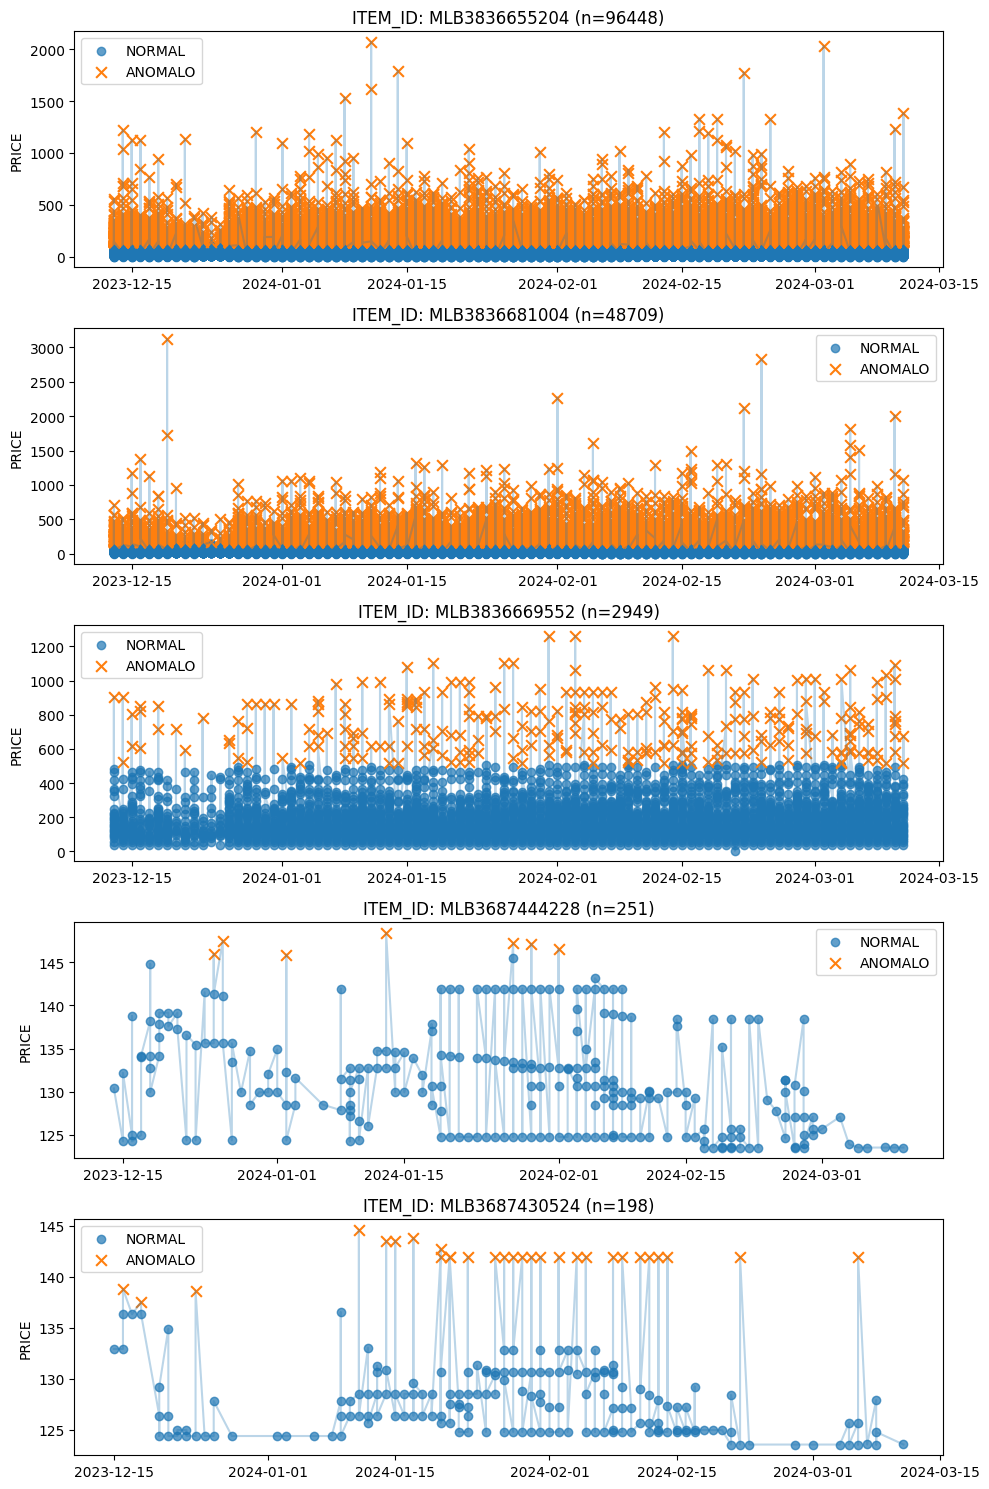

In [15]:
top_items = df_feat["ITEM_ID"].value_counts().head(5).index.tolist()

fig, axes = plt.subplots(len(top_items), 1, figsize=(10, 3 * len(top_items)), sharex=False)
if len(top_items) == 1:
    axes = [axes]

for ax, item in zip(axes, top_items):
    subset = df_feat[df_feat["ITEM_ID"] == item].copy()

    # Separar normales vs atípicos
    normales = subset[subset["is_anom_mad"] == 0]
    atipicos = subset[subset["is_anom_mad"] == 1]

    # Línea base con todos los puntos
    ax.plot(
        subset["ORD_CLOSED_DT"],
        subset["PRICE"],
        linestyle="-",
        alpha=0.3,
        label="_nolegend_",
    )

    # Normales
    ax.scatter(
        normales["ORD_CLOSED_DT"],
        normales["PRICE"],
        marker="o",
        alpha=0.7,
        label="NORMAL",
    )

    # Atípicos
    ax.scatter(
        atipicos["ORD_CLOSED_DT"],
        atipicos["PRICE"],
        marker="x",
        s=60,
        label="ANOMALO",
    )

    ax.set_title(f"ITEM_ID: {item} (n={len(subset)})")
    ax.set_ylabel("PRICE")
    ax.legend()

plt.tight_layout()
plt.show()

Para realizar el proceso de los modelos por facildiad usaremos una muestra aletoria de 50 items

In [16]:
# sample 50 items con sus features
item_counts = df_feat["ITEM_ID"].value_counts()
item_counts.describe()


count      300.000000
mean       586.380000
std       6224.153652
min         34.000000
25%         69.000000
50%         89.000000
75%        113.250000
max      96448.000000
Name: count, dtype: float64

In [17]:
eligible_items = item_counts[item_counts >= 100]
print("ITEM_ID elegibles:", len(eligible_items))


ITEM_ID elegibles: 110


In [18]:
item_ids_sample = (
    eligible_items
    .sample(n=50, random_state=42)
    .index
    .tolist()
)

In [19]:
df_model = df_feat[df_feat["ITEM_ID"].isin(item_ids_sample)].copy()

df_model.shape, df_model["ITEM_ID"].nunique()

((103056, 11), 50)

## Modelo B clásico — Isolation Forest

En esta sección utilizamos las features construidas (`price_norm`, `pct_change_vs_prev`) para entrenar un modelo clásico de detección de anomalías basado en **Isolation Forest**.

- `is_anom_mad` (derivada de la regla MAD) actúa como referencia/"verdad proxy".
- `is_anom_iforest` será la salida del Modelo B.

Calcularemos **F1**, **precision** y **recall** de `is_anom_iforest` contra `is_anom_mad` para evaluar qué tan bien el modelo clásico replica o mejora el criterio heurístico.

In [20]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
)


In [21]:

# Features que usaremos (puedes ajustar)
features = ["price_norm", "pct_change_vs_prev"]

# Rellenar NaN (ej: primeras filas sin prev, etc.)
df_model[features] = df_model[features].fillna(0)


In [22]:
# orden global por fecha
df_model = df_model.sort_values(["ORD_CLOSED_DT"]).reset_index(drop=True)

# 
cutoff_date = df_model["ORD_CLOSED_DT"].quantile(0.8)
cutoff_date

Timestamp('2024-02-25 00:00:00')

In [23]:
train = df_model[df_model["ORD_CLOSED_DT"] <= cutoff_date].copy()
test  = df_model[df_model["ORD_CLOSED_DT"] >  cutoff_date].copy()

X_train = train[features].to_numpy()
X_test  = test[features].to_numpy()

y_train_ref = train["is_anom_mad"].to_numpy()  # solo para estadística, no para entrenar
y_test_ref  = test["is_anom_mad"].to_numpy()   # este es tu ground truth de evaluación

In [24]:
raw_contamination = y_train_ref.mean()
contamination = float(np.clip(raw_contamination, 0.01, 0.3))  # por si acaso

print("Contamination estimado:", raw_contamination, "→ usado:", contamination) 

Contamination estimado: 0.1546700115785411 → usado: 0.1546700115785411


In [25]:
iso = IsolationForest(
    n_estimators=100,
    contamination=contamination,
    random_state=42,
    n_jobs=-1,
)

iso.fit(X_train) 

,n_estimators,100
,max_samples,'auto'
,contamination,0.1546700115785411
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


In [26]:
# Scores de anomalía (cuanto más NEGATIVO, más anómalo)
scores_test = iso.decision_function(X_test)

# Predicción binaria: 1 = normal, -1 = anómalo (convención sklearn)
y_pred_iso = iso.predict(X_test)
y_pred_iso_bin = (y_pred_iso == -1).astype(int)  # 1 = anómalo, 0 = normal

## Modelo A — LLM (Gemini)

En esta sección se implementa el modelo basado en LLM (Gemini) que clasifica cada transacción de precio como `ANOMALO` o `NORMAL`, devolviendo además `confidence` y `reason`. Luego se comparan sus métricas contra el modelo clásico (Isolation Forest).

In [27]:
# Setup Gemini (Modelo A)

# Cargar variables de entorno desde .env si existe
load_dotenv()

api_key = os.getenv("GEMINI_API_KEY")
if api_key is None or api_key.strip() == "":
    raise ValueError("GEMINI_API_KEY no encontrada en variables de entorno")

# Quitar comillas accidentales si se definió como "KEY" en .env
api_key = api_key.strip().strip('"').strip("'")

genai.configure(api_key=api_key)

gemini_model_name = "models/gemini-2.5-flash"

gemini_model = genai.GenerativeModel(
    gemini_model_name,
    generation_config={
        "response_mime_type": "application/json",
    },
)

print("Gemini configurado con modelo:", gemini_model_name)

Gemini configurado con modelo: models/gemini-2.5-flash


In [28]:
# DataFrame de evaluación para el A/B test (Modelo B vs referencia)

# Partimos del conjunto de test definido antes (20% más reciente en el tiempo)
# y añadimos las predicciones del Isolation Forest y el score continuo.

test_eval = test.copy().reset_index(drop=True)

test_eval["iforest_score"] = scores_test
test_eval["is_anom_iforest"] = y_pred_iso_bin

# Usaremos is_anom_mad como ground truth / label_heur
test_eval["label_heur"] = test_eval["is_anom_mad"].astype(int)

print("Shape test_eval:", test_eval.shape)
print(test_eval["label_heur"].value_counts(normalize=True))

Shape test_eval: (20144, 14)
label_heur
0    0.847597
1    0.152403
Name: proportion, dtype: float64


In [29]:
item_stats = (
    test_eval
    .groupby("ITEM_ID")["label_heur"]
    .agg(
        n_obs="size",
        n_pos="sum"
    )
)
item_stats["n_neg"] = item_stats["n_obs"] - item_stats["n_pos"]

item_stats.head()

,n_obs,n_pos,n_neg
ITEM_ID,,,
MLB1632127417,33,2,31
MLB1813853929,18,5,13
MLB1813860569,20,15,5
MLB2173579748,33,1,32
MLB2202276400,30,6,24


In [30]:
MIN_POS = 1   # mínimo de anomalías (label_heur=1)
MIN_NEG = 1   # mínimo de normales (label_heur=0)

eligible_items = item_stats[
    (item_stats["n_pos"] >= MIN_POS) &
    (item_stats["n_neg"] >= MIN_NEG)
]

print("ITEM_ID elegibles para LLM:", len(eligible_items))

ITEM_ID elegibles para LLM: 27


In [31]:
N_ITEMS_LLM = 10  # ajústalo según tu cuota

items_for_llm = (
    eligible_items
    .sample(n=min(N_ITEMS_LLM, len(eligible_items)), random_state=42)
    .index
    .tolist()
)

items_for_llm

['MLB3026196577',
 'MLB3342582093',
 'MLB3086996119',
 'MLB4072491478',
 'MLB1632127417',
 'MLB3269776012',
 'MLB3511034319',
 'MLB3687430524',
 'MLB3340704535',
 'MLB4273575930']

In [32]:
max_per_item_per_class = 3  # ej: hasta 3 normales y 3 anómalos por item

parts = []

for item_id in items_for_llm:
    df_item = test_eval[test_eval["ITEM_ID"] == item_id]

    for label_value in [0, 1]:
        subset = df_item[df_item["label_heur"] == label_value]
        if len(subset) == 0:
            continue

        n_sample = min(max_per_item_per_class, len(subset))
        parts.append(subset.sample(n=n_sample, random_state=42))

if not parts:
    raise ValueError("No se pudo construir df_llm: no hay suficientes datos por item/clase.")

df_llm = pd.concat(parts, ignore_index=True)

# Mezclamos para no agrupar por item/clase en el orden
df_llm = df_llm.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Shape df_llm:", df_llm.shape)
print("Clases en df_llm:")
print(df_llm["label_heur"].value_counts())
print("Items en df_llm:")
print(df_llm["ITEM_ID"].nunique(), "ITEM_ID distintos")

Shape df_llm: (47, 14)
Clases en df_llm:
label_heur
0    30
1    17
Name: count, dtype: int64
Items en df_llm:
10 ITEM_ID distintos


Para el A/B test cuantitativo, usamos una muestra estratificada de 10 productos, con hasta 3 observaciones por clase (normal/anómalo) por producto, para optimizar el consumo de LLM manteniendo representatividad.

In [33]:
# # Subconjunto de test para el LLM (muestreo estratificado por label_heur)

# max_per_class = 5  # puedes ajustar este número según presupuesto/latencia
# parts = []

# for label_value in [0, 1]:
#     subset = test_eval[test_eval["label_heur"] == label_value]
#     if len(subset) == 0:
#         continue
#     n_sample = min(max_per_class, len(subset))
#     parts.append(subset.sample(n=n_sample, random_state=42))

# if len(parts) == 0:
#     raise ValueError("No hay datos en test_eval para construir df_llm")

# df_llm = pd.concat(parts, ignore_index=True)

# # Mezclar el orden para no sesgar por clase
# df_llm = df_llm.sample(frac=1.0, random_state=42).reset_index(drop=True)

# print("Shape df_llm:", df_llm.shape)
# print(df_llm["label_heur"].value_counts())

In [34]:
# Funciones auxiliares para construir el contexto y llamar al LLM

def build_price_context(row: pd.Series) -> str:
    item_id = row["ITEM_ID"]
    price = float(row["PRICE"])
    date = row["ORD_CLOSED_DT"]

    price_median = float(row["price_median"])
    price_mad = float(row["price_mad"])

    price_prev = row.get("price_prev", np.nan)
    pct_change = row.get("pct_change_vs_prev", np.nan)

    n_obs = None
    if item_id in stats_extra.index:
        stats_row = stats_extra.loc[item_id]
        n_obs = int(stats_row["n_obs"])

    def fmt(x):
        if pd.isna(x):
            return "NA"
        try:
            return f"{float(x):.4f}"
        except Exception:
            return str(x)

    lines = []
    lines.append(f"ITEM_ID: {item_id}")
    if n_obs is not None:
        lines.append(f"Número de observaciones históricas de este producto: {n_obs}")
    lines.append(f"Mediana histórica de precio: {price_median:.2f}")
    lines.append(f"Desviación absoluta mediana (MAD) de precio: {price_mad:.2f}")
    lines.append("")
    lines.append("Transacción actual:")
    lines.append(f"Fecha: {date}")
    lines.append(f"Precio actual: {price:.2f}")
    lines.append(f"Precio anterior del mismo producto: {fmt(price_prev)}")
    lines.append(f"Cambio relativo respecto al precio anterior: {fmt(pct_change)}")

    return "\n".join(lines)



def build_llm_prompt(row: pd.Series) -> str:
    contexto = build_price_context(row)

    instrucciones = (
        "Eres un analista de datos especializado en detectar anomalías de precios en un e-commerce.\n"
        "A partir del contexto del producto y de la transacción actual, decide si el punto de precio es ANOMALO o NORMAL.\n"
        "Criterios orientativos:\n"
        "- ANOMALO: precio muy alejado de la mediana histórica o cambio relativo extremo respecto al último precio.\n"
        "- NORMAL: precio dentro del rango típico del producto.\n\n"
        "Devuelve exclusivamente un JSON válido con la siguiente estructura:\n\n"
        "{\n"
        '  "label": "ANOMALO" o "NORMAL",\n'
        '  "confidence": número entre 0 y 1,\n'
        '  "reason": "explicación corta en español (máximo 15 palabras)"\n'
        "}\n\n"
        "No añadas texto fuera de ese JSON."
    )

    prompt = instrucciones + "\n\nContexto:\n" + contexto
    return prompt



def call_gemini_for_row(row: pd.Series):
    """Llama a Gemini para una fila y devuelve (label, confidence, reason, latency_ms, raw_text).

    Si se alcanza la cuota gratuita (ResourceExhausted), devuelve label=None y reason="quota_exceeded: ...".
    """

    prompt = build_llm_prompt(row)

    t0 = time.time()
    try:
        response = gemini_model.generate_content(prompt)
        latency_ms = (time.time() - t0) * 1000.0
    except ResourceExhausted as e:
        latency_ms = (time.time() - t0) * 1000.0
        # No rompemos el bucle: marcamos explícitamente error de cuota
        return None, None, f"quota_exceeded: {e}", latency_ms, ""

    raw_text = response.text

    label = None
    confidence = None
    reason = None

    try:
        data = json.loads(raw_text)
        label_str = str(data.get("label", "")).strip().upper()
        if label_str == "ANOMALO":
            label = 1
        elif label_str == "NORMAL":
            label = 0

        conf_val = data.get("confidence", None)
        if conf_val is not None:
            confidence = float(conf_val)

        reason_val = data.get("reason", None)
        if reason_val is not None:
            reason = str(reason_val)
    except Exception as e:
        reason = f"parse_error: {e}"

    return label, confidence, reason, latency_ms, raw_text


In [35]:
df_llm.head()

,ITEM_ID,ORD_CLOSED_DT,PRICE,price_median,price_mad,price_log,price_norm,price_prev,pct_change_vs_prev,mad_score,is_anom_mad,iforest_score,is_anom_iforest,label_heur
0,MLB3269776012,2024-02-26,311.6190,111.1505,51.36495,5.741781,3.902827,69.5019,3.483604,3.902827,1,-0.005491,1,1
1,MLB3340704535,2024-03-08,1206.2900,1202.8749,24.27490,7.095305,0.140684,1206.2900,0.000000,0.140684,0,0.115276,0,0
2,MLB3269776012,2024-02-29,393.8370,111.1505,51.36495,5.975937,5.503490,115.2330,2.417745,5.503490,1,-0.022398,1,1
3,MLB4273575930,2024-02-26,30.7501,30.4590,1.34900,3.425893,0.215789,30.0472,0.023393,0.215789,0,0.113443,0,0
4,MLB3269776012,2024-03-04,86.6839,111.1505,51.36495,4.462268,-0.476329,138.4500,-0.373897,0.476329,0,0.117206,0,0


In [36]:
# Llamadas al LLM sobre df_llm
# ADVERTENCIA: esta celda hace una llamada a Gemini por fila de df_llm.

llm_labels = []
llm_confidences = []
llm_reasons = []
llm_latencies = []
llm_raw_responses = []

for idx, row in df_llm.iterrows():
    label, conf, reason, latency_ms, raw_text = call_gemini_for_row(row)
    llm_labels.append(label)
    llm_confidences.append(conf)
    llm_reasons.append(reason)
    llm_latencies.append(latency_ms)
    llm_raw_responses.append(raw_text)

df_llm["label_llm"] = llm_labels
df_llm["confidence_llm"] = llm_confidences
df_llm["reason_llm"] = llm_reasons
df_llm["latency_ms_llm"] = llm_latencies
df_llm["raw_response_llm"] = llm_raw_responses

df_llm.head()

,ITEM_ID,ORD_CLOSED_DT,PRICE,price_median,price_mad,price_log,price_norm,price_prev,pct_change_vs_prev,mad_score,is_anom_mad,iforest_score,is_anom_iforest,label_heur,label_llm,confidence_llm,reason_llm,latency_ms_llm,raw_response_llm
0,MLB3269776012,2024-02-26,311.6190,111.1505,51.36495,5.741781,3.902827,69.5019,3.483604,3.902827,1,-0.005491,1,1,1.0,0.98,Precio muy superior a la mediana histórica y u...,4906.996489,"{\n ""label"": ""ANOMALO"",\n ""confidence"": 0.98..."
1,MLB3340704535,2024-03-08,1206.2900,1202.8749,24.27490,7.095305,0.140684,1206.2900,0.000000,0.140684,0,0.115276,0,0,0.0,0.99,El precio actual es casi idéntico al anterior ...,6913.717031,"{\n ""label"": ""NORMAL"",\n ""confidence"": 0.99,..."
2,MLB3269776012,2024-02-29,393.8370,111.1505,51.36495,5.975937,5.503490,115.2330,2.417745,5.503490,1,-0.022398,1,1,1.0,0.95,Precio muy alejado de la mediana histórica y c...,3838.400602,"{\n ""label"": ""ANOMALO"",\n ""confidence"": 0.95..."
3,MLB4273575930,2024-02-26,30.7501,30.4590,1.34900,3.425893,0.215789,30.0472,0.023393,0.215789,0,0.113443,0,0,0.0,0.98,Precio actual muy cerca de la mediana históric...,3758.926392,"{\n ""label"": ""NORMAL"",\n ""confidence"": 0.98,..."
4,MLB3269776012,2024-03-04,86.6839,111.1505,51.36495,4.462268,-0.476329,138.4500,-0.373897,0.476329,0,0.117206,0,0,0.0,0.85,Precio actual cercano a la mediana histórica y...,10269.553423,"{\n ""label"": ""NORMAL"",\n ""confidence"": 0.85,..."


In [46]:
print(df_llm["label_llm"].value_counts(dropna=False))

# Quedarnos solo con filas donde el LLM devolvió un label válido 0/1
df_llm_clean = df_llm[df_llm["label_llm"].isin([0, 1])].copy()

print("Filas totales LLM:", len(df_llm))
print("Filas con label válido:", len(df_llm_clean))
print(df_llm_clean["label_heur"].value_counts(normalize=True))


label_llm
0.0    23
1.0    21
NaN     3
Name: count, dtype: int64
Filas totales LLM: 47
Filas con label válido: 44
label_heur
0    0.636364
1    0.363636
Name: proportion, dtype: float64


In [47]:
# Métricas y A/B test: Modelo A (LLM) vs Modelo B (Isolation Forest) contra label_heur

# Filtrar filas donde el LLM devolvió una etiqueta válida
mask_valid = df_llm["label_llm"].isin([0, 1])
df_eval_llm = df_llm[mask_valid].copy()

print("Filas con predicción válida del LLM:", len(df_eval_llm), "de", len(df_llm))

y_true = df_eval_llm["label_heur"].astype(int).values
y_pred_A = df_eval_llm["label_llm"].astype(int).values
y_pred_B = df_eval_llm["is_anom_iforest"].astype(int).values

# Scores continuos
scores_A = df_eval_llm["confidence_llm"].fillna(0.5).astype(float).values
# Para Isolation Forest, scores más negativos son más anómalos, invertimos el signo
scores_B = (-df_eval_llm["iforest_score"]).astype(float).values


def compute_metrics(y_true, y_pred, scores):
    return {
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "pr_auc": average_precision_score(y_true, scores),
    }


metrics_A = compute_metrics(y_true, y_pred_A, scores_A)
metrics_B = compute_metrics(y_true, y_pred_B, scores_B)

print("\nMétricas Modelo A (LLM) vs label_heur:")
for k, v in metrics_A.items():
    print(f"  {k}: {v:.4f}")

print("\nMétricas Modelo B (IForest) vs label_heur (mismas filas):")
for k, v in metrics_B.items():
    print(f"  {k}: {v:.4f}")

print("\nLatencia media LLM (ms por llamada):", df_eval_llm["latency_ms_llm"].mean())

# Aproximar latencia por punto del modelo clásico en el conjunto de test completo
start = time.time()
_ = iso.predict(X_test)
latency_iso_total_ms = (time.time() - start) * 1000.0
latency_iso_per_row_ms = latency_iso_total_ms / len(X_test)
print("Latencia media modelo clásico (ms por fila, aprox.):", latency_iso_per_row_ms)


Filas con predicción válida del LLM: 44 de 47

Métricas Modelo A (LLM) vs label_heur:
  f1: 0.8649
  precision: 0.7619
  recall: 1.0000
  pr_auc: 0.3766

Métricas Modelo B (IForest) vs label_heur (mismas filas):
  f1: 0.6429
  precision: 0.7500
  recall: 0.5625
  pr_auc: 0.8610

Latencia media LLM (ms por llamada): 5708.773266185413
Latencia media modelo clásico (ms por fila, aprox.): 0.003470171529968359


In [48]:
def bootstrap_delta_f1_stratified(df, n_boot=1000, random_state=42):
    """
    df debe tener columnas:
    - ITEM_ID
    - label_heur
    - pred_A
    - pred_B
    """
    rng = np.random.default_rng(random_state)
    item_ids = df["ITEM_ID"].unique()

    deltas = []

    y_true_all = df["label_heur"].to_numpy()
    y_A_all = df["label_llm"].to_numpy()
    y_B_all = df["is_anom_iforest"].to_numpy()
    items_all = df["ITEM_ID"].to_numpy()

    for _ in range(n_boot):
        # muestreamos ITEM_IDs con reemplazo
        sampled_items = rng.choice(item_ids, size=len(item_ids), replace=True)
        mask = np.isin(items_all, sampled_items)

        y_true_bs = y_true_all[mask]
        y_A_bs = y_A_all[mask]
        y_B_bs = y_B_all[mask]

        f1_A = f1_score(y_true_bs, y_A_bs, zero_division=0)
        f1_B = f1_score(y_true_bs, y_B_bs, zero_division=0)
        deltas.append(f1_A - f1_B)

    deltas = np.array(deltas)
    delta_mean = float(deltas.mean())
    ci_low, ci_high = np.percentile(deltas, [2.5, 97.5])

    # p-value bilateral
    if delta_mean >= 0:
        p_one_side = (deltas <= 0).mean()
    else:
        p_one_side = (deltas >= 0).mean()
    p_value = float(2 * p_one_side)

    return {
        "delta_mean": delta_mean,
        "ci_low": float(ci_low),
        "ci_high": float(ci_high),
        "p_value": p_value,
    }

In [49]:
boot_res = bootstrap_delta_f1_stratified(df_eval_llm, n_boot=1000, random_state=42)
print("\nA/B Test ΔF1 = F1(LLM) - F1(Clásico) (bootstrap estratificado por ITEM_ID)")
print(f"ΔF1 medio: {boot_res['delta_mean']:.4f}")
print(f"IC95%: [{boot_res['ci_low']:.4f}, {boot_res['ci_high']:.4f}]")
print(f"p-value (aprox.): {boot_res['p_value']:.4f}")


A/B Test ΔF1 = F1(LLM) - F1(Clásico) (bootstrap estratificado por ITEM_ID)
ΔF1 medio: 0.2393
IC95%: [0.0186, 0.5334]
p-value (aprox.): 0.0120


In [50]:
cols_llm = [
    "ITEM_ID",
    "ORD_CLOSED_DT",
    "PRICE",
    "label_llm",
    "confidence_llm",
    "reason_llm",
    "latency_ms_llm",
]

df_llm_small = df_llm[cols_llm].copy()

# Hacemos el merge sobre test_eval para tener TODAS las filas
test_eval_with_llm = test_eval.merge(
    df_llm_small,
    on=["ITEM_ID", "ORD_CLOSED_DT", "PRICE"],
    how="left",
)

print("Shape original test_eval:", test_eval.shape)
print("Shape test_eval_with_llm:", test_eval_with_llm.shape)
print("Filas con LLM:", test_eval_with_llm["label_llm"].notna().sum())
print("ITEM_ID con LLM:", test_eval_with_llm.loc[test_eval_with_llm["label_llm"].notna(), "ITEM_ID"].nunique())

Shape original test_eval: (20144, 14)
Shape test_eval_with_llm: (20144, 18)
Filas con LLM: 44
ITEM_ID con LLM: 10


In [51]:
items_with_llm = (
    test_eval_with_llm
    .loc[test_eval_with_llm["label_llm"].notna(), "ITEM_ID"]
    .value_counts()
    .head(3)
    .index
    .tolist()
)

items_with_llm

['MLB3086996119', 'MLB1632127417', 'MLB3269776012']

In [ ]:
import matplotlib.pyplot as plt

def plot_item_A_vs_B_full_history(df_item, k_mad=3.0):
    df_item = df_item.sort_values("ORD_CLOSED_DT").copy()
    item_id = df_item["ITEM_ID"].iloc[0]

    median = df_item["price_median"].iloc[0]
    mad    = df_item["price_mad"].iloc[0]

    mask_B = df_item["is_anom_iforest"].fillna(0).astype(int) == 1
    mask_A_valid = df_item["label_llm"].isin([0, 1])
    mask_A_anom  = mask_A_valid & (df_item["label_llm"] == 1)

    mask_H = df_item["label_heur"] == 1

    # --- Intersecciones ---
    mask_AB   = mask_A_anom & mask_B
    mask_ABH  = mask_AB & mask_H

    plt.figure(figsize=(12, 4))

    # Serie completa
    plt.plot(
        df_item["ORD_CLOSED_DT"],
        df_item["PRICE"],
        linestyle="-",
        marker="o",
        alpha=0.3,
        label="Precio"
    )

    # Mediana + MAD
    plt.axhline(median, linestyle="--", alpha=0.8, label="Mediana histórica")
    plt.axhline(median + k_mad * mad, linestyle=":", alpha=0.8,
                label=f"Mediana + {k_mad}·MAD")


    # Heurístico
    plt.scatter(
        df_item.loc[mask_H, "ORD_CLOSED_DT"],
        df_item.loc[mask_H, "PRICE"],
        facecolors="none",
        edgecolors="black",
        s=150,
        linewidths=1.5,
        label="Heurístico (H)"
    )

    # Clásico (B)
    plt.scatter(
        df_item.loc[mask_B, "ORD_CLOSED_DT"],
        df_item.loc[mask_B, "PRICE"],
        marker="x",
        s=60,
        label="Anómalo Clásico (B)"
    )

    # LLM (A)
    plt.scatter(
        df_item.loc[mask_A_anom, "ORD_CLOSED_DT"],
        df_item.loc[mask_A_anom, "PRICE"],
        marker="^",
        s=80,
        label="Anómalo LLM (A)"
    )


    # A ∩ B
    plt.scatter(
        df_item.loc[mask_AB, "ORD_CLOSED_DT"],
        df_item.loc[mask_AB, "PRICE"],
        marker="s",
        s=90,
        facecolors="none",
        edgecolors="red",
        linewidths=1.8,
        label="A ∩ B"
    )

    # A ∩ B ∩ H
    plt.scatter(
        df_item.loc[mask_ABH, "ORD_CLOSED_DT"],
        df_item.loc[mask_ABH, "PRICE"],
        marker="*",
        s=220,
        color="gold",
        edgecolors="black",
        linewidths=1,
        label="A ∩ B ∩ H"
    )

    plt.title(f"ITEM_ID = {item_id}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()


In [53]:
test_eval_with_llm

,ITEM_ID,ORD_CLOSED_DT,PRICE,price_median,price_mad,price_log,price_norm,price_prev,pct_change_vs_prev,mad_score,is_anom_mad,iforest_score,is_anom_iforest,label_heur,label_llm,confidence_llm,reason_llm,latency_ms_llm
0,MLB4076135260,2024-02-26,808.6900,865.49000,42.60000,6.695416,-1.333333,808.6900,0.000000,1.333333,0,0.068243,0,0,NaN,NaN,NaN,NaN
1,MLB1813860569,2024-02-26,45.8305,45.89440,1.43420,3.824950,-0.044554,45.8305,0.000000,0.044554,0,0.113724,0,0,NaN,NaN,NaN,NaN
2,MLB3433235400,2024-02-26,94.2596,70.87930,1.07920,4.546053,21.664454,94.2596,0.000000,21.664454,1,-0.220233,1,1,NaN,NaN,NaN,NaN
3,MLB4293467490,2024-02-26,28.0876,27.43440,0.29820,3.335328,2.190469,28.0876,0.000000,2.190469,0,0.081933,0,0,NaN,NaN,NaN,NaN
4,MLB4276994026,2024-02-26,100.7987,99.21185,0.87685,4.613125,1.809715,101.2247,-0.004208,1.809715,0,0.095842,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20139,MLB3836655204,2024-03-11,6.9367,47.49900,30.46610,1.936826,-1.331391,11.2038,-0.380862,1.331391,0,0.077204,0,0,NaN,NaN,NaN,NaN
20140,MLB3836655204,2024-03-11,11.2038,47.49900,30.46610,2.416253,-1.191331,43.3526,-0.741566,1.191331,0,0.093722,0,0,NaN,NaN,NaN,NaN
20141,MLB3836655204,2024-03-11,43.3526,47.49900,30.46610,3.769367,-0.136099,20.7462,1.089665,0.136099,0,0.080974,0,0,NaN,NaN,NaN,NaN
20142,MLB3836655204,2024-03-11,4.2174,47.49900,30.46610,1.439219,-1.420648,15.1301,-0.721258,1.420648,0,0.063564,0,0,NaN,NaN,NaN,NaN


In [58]:
for item in items_with_llm:
    df_item = test_eval_with_llm[test_eval_with_llm["ITEM_ID"] == item]
    plot_item_A_vs_B_full_history(df_item, k_mad=3.0)

    plt.savefig("../visualizations/ej1_item_" + str(item) + ".png", dpi=150, bbox_inches="tight")
    plt.close()  # Importante para evitar superposición de figuras

